# Analysis results

In this notebook we'll try to get the some idea about the final sensitivity of the trilep channel.


First, we import all the packages we need and load histograms from a cache.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re

import numpy as np
import pandas as pd

from coffea import hist

from klepto.archives import dir_archive

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

In [2]:
# get one of our already existing caches
cache_dir = '../caches/'
cache_name = 'SS_analysis_2018'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

In [3]:
# redefine some labels and colors
my_labels = {
        'topW_v3': 'top-W scat.',
        'topW_EFT_cp8': 'EFT, cp8',
        'topW_EFT_mix': 'EFT mix',
        'TTZ': r'$t\bar{t}Z$',
        'TTW': r'$t\bar{t}W$',
        'TTH': r'$t\bar{t}H$',
        'diboson': 'VV/VVV',
        'rare': 'rare',
        'ttbar': r'$t\bar{t}$',
        'XG': 'XG',  # this is bare XG
        'conv_mc': 'conversion',
        'np_obs_mc': 'nonprompt (MC true)',
        'np_est_mc': 'nonprompt (MC est)',
        'cf_obs_mc': 'charge flip (MC true)',
        'cf_est_mc': 'charge flip (MC est)',
        'np_est_data': 'nonprompt (est)',
        'cf_est_data': 'charge flip (est)',
}

my_colors = {
        'topW_v3': '#FF595E',
        'topW_EFT_cp8': '#000000',
        'topW_EFT_mix': '#0F7173',
        'TTZ': '#FFCA3A',
        'TTW': '#8AC926',
        'TTH': '#34623F',
        'diboson': '#525B76',
        'rare': '#EE82EE',
        'ttbar': '#1982C4',
        'XG': '#5bc0de',
        'conv_mc': '#5bc0de',
        'np_obs_mc': '#1982C4',
        'np_est_mc': '#1982C4',
        'np_est_data': '#1982C4',
        'cf_obs_mc': '#0F7173',
        'cf_est_mc': '#0F7173',
        'cf_est_data': '#0F7173',
}

Data: 0 MC: 53.54


/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


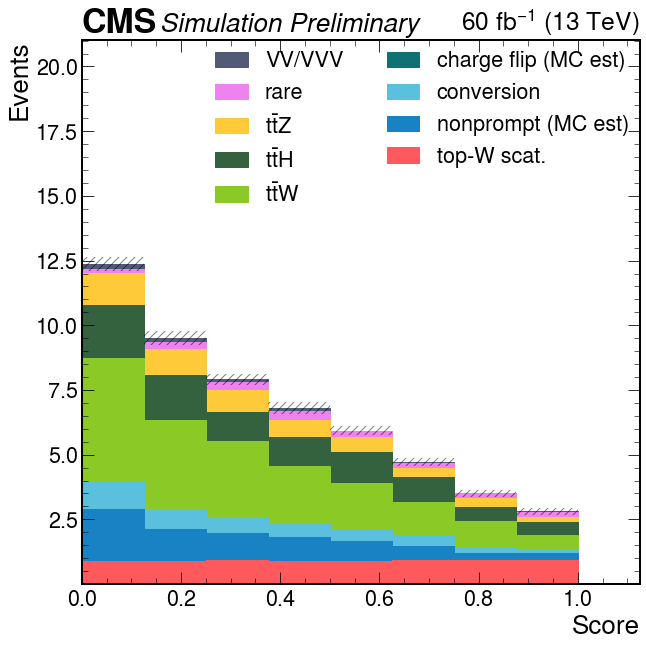

In [4]:
# check out that the histogram we want is actually there
all_processes = [ x[0] for x in output['N_ele'].values().keys() ]
data_all = ['DoubleMuon', 'MuonEG', 'EGamma', 'SingleMuon']
data    = data_all
order   = ['topW_v3', 'np_est_mc', 'conv_mc', 'cf_est_mc', 'TTW', 'TTH', 'TTZ','rare', 'diboson']
signals = []
omit    = [ x for x in all_processes if (x not in signals and x not in order and x not in data) ]

lumi = 60

score_bins = hist.Bin("score",          r"N", 8, 0, 1)

mass_bins_coarse = hist.Bin('mass', r'$M\ (GeV)$', [0,100,150,200,400])

makePlot(output, 'node0_score_transform_pp', 'score',
     data=[],
     bins=score_bins, log=False, normalize=False, axis_label='Score',
     new_colors=my_colors, new_labels=my_labels, lumi=lumi,
     order=order,
     signals=signals,
     omit=omit+data,
     #save=os.path.expandvars(plot_dir+sub_dir+'node0_score_transform_pp'),
    )

# Limits

A few tools are in place that interface with the [combine tool](https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit), documentation can be found [here](http://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/). The statistical backgrounds can be found in [this paper](https://cds.cern.ch/record/1379837?ln=en).


In [5]:
from Tools.dataCard import dataCard
from Tools.limits import makeCardFromHist

In order for this to run we first need to install the combine tool.

In your terminal on the uaf:
- navigate to your home directory
- make a new directory called "combine"

Then run the following commands:
```
cd combine
cmsrel CMSSW_10_2_13
cd CMSSW_10_2_13/src
cmsenv
git clone https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit.git HiggsAnalysis/CombinedLimit
cd HiggsAnalysis/CombinedLimit
git fetch origin
git checkout v8.0.1
scramv1 b clean; scramv1 b # always make a clean build
```


In [6]:
card = dataCard(releaseLocation=os.path.expandvars('/home/users/$USER/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/'))

Before we can start, we need to get the histogram in the correct shape.
We want to:
- Remove real data entries
- Any signal processes we're not interested in right now, like topW_EFT_cp8 and topW_EFT_mix
- Group DY and diboson into a *rare* category, and keep all others
- Rebin the mass axis to something sensible, similar to what we've done above.

For removing datasets we don't want to look at we can use regular expressions (the *re* package)

In [7]:
no_data_or_signal  = re.compile('(?!(%s))'%('|'.join(omit)))

regions = [
    ('SR_1', 'node0_score_transform_pp'),
    ('SR_2', 'node0_score_transform_mm'),
    ('CR', 'node1_score'),
]

mapping = {
    'rare': ['rare', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'nonprompt': ['np_est_mc'],
    'chargeflip': ['cf_est_mc'],
    'conversion': ['conv_mc'],
    'signal': ['topW_v3'],
}

new_hists = {}
for short_name, long_name in regions:
    new_hists[short_name] = output[long_name][no_data_or_signal]
    new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
    new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)

In [8]:
# check that all of this actually worked
for process in list(new_hists['CR'].values().keys()):
    print (process[0])

rare
TTW
TTZ
TTH
nonprompt
chargeflip
conversion
signal


In [9]:
new_hists['SR_1'].values()

{('rare',): array([0.34072918, 0.40393628, 0.40476208, 0.45911803, 0.24741006,
        0.22092853, 0.20701334, 0.20817163]),
 ('TTW',): array([4.76634352, 3.45712863, 2.93329127, 2.21132898, 1.81520286,
        1.34215596, 1.02269847, 0.5695482 ]),
 ('TTZ',): array([1.23650663, 1.03104696, 0.85511007, 0.66491074, 0.57187654,
        0.36254359, 0.31593526, 0.19701019]),
 ('TTH',): array([2.05549177, 1.70403389, 1.12962879, 1.1209628 , 1.21104682,
        0.94796599, 0.56907605, 0.5012222 ]),
 ('nonprompt',): array([2.00881606, 1.25592   , 1.04078212, 0.92236632, 0.75502383,
        0.55786082, 0.28387621, 0.25225974]),
 ('chargeflip',): array([0., 0., 0., 0., 0., 0., 0., 0.]),
 ('conversion',): array([1.05909431, 0.75153732, 0.61227939, 0.52237874, 0.42505828,
        0.35578507, 0.19307755, 0.14033212]),
 ('signal',): array([0.89492535, 0.89038864, 0.92856052, 0.90347047, 0.90592542,
        0.93058288, 0.92166695, 0.9390291 ])}

In [10]:
import uproot3

# name, magnitude, processes
systematics = [
    ('ttw_norm', 1.15, 'TTW'),
    ('ttz_norm', 1.10, 'TTZ'),
    ('tth_norm', 1.20, 'TTH'),
    ('rare_norm', 1.20, 'rare'),
    ('nonprompt_norm', 1.30, 'nonprompt'),
    ('chargeflip_norm', 1.20, 'chargeflip'),
    ('conversion_norm', 1.20, 'conversion')
]

def makeCardFromHist(
    out_cache,
    hist_name,
    scales={'nonprompt':1, 'signal':1},
    overflow='all',
    ext='',
    systematics={},):

    print ("Writing cards using histogram:", hist_name)
    card_dir = os.path.expandvars('$TWHOME/data/cards/')
    if not os.path.isdir(card_dir):
        os.makedirs(card_dir)
    
    data_card = card_dir+hist_name+ext+'_card.txt'
    shape_file = card_dir+hist_name+ext+'_shapes.root'
    
    histogram = out_cache[hist_name].copy()
    #histogram = histogram.rebin('mass', bins[hist_name]['bins'])
    
    # scale some processes
    histogram.scale(scales, axis='dataset')
    
    ## making a histogram for pseudo observation. this hurts, but rn it seems to be the best option
    data_counts = np.asarray(np.round(histogram.integrate('dataset').values(overflow=overflow)[()], 0), int)
    data_hist = histogram['signal']
    data_hist.clear()
    data_hist_bins = data_hist.axes()[1]
    for i, edge in enumerate(data_hist_bins.edges(overflow=overflow)):
        if i >= len(data_counts): break
        for y in range(data_counts[i]):
            data_hist.fill(**{'dataset': 'data', data_hist_bins.name: edge+0.0001})


    fout = uproot3.recreate(shape_file)

    processes = [ p[0] for p in list(histogram.values().keys()) if p[0] != 'signal']  # ugly conversion
    
    for process in processes + ['signal']:
        fout[process] = hist.export1d(histogram[process].integrate('dataset'), overflow=overflow)
        
    fout["data_obs"]  = hist.export1d(histogram.integrate('dataset'), overflow=overflow)
    fout.close()
    
    # Get the total yields to write into a data card
    totals = {}
    
    for process in processes + ['signal']:
        totals[process] = histogram[process].integrate('dataset').values(overflow=overflow)[()].sum()
    
    totals['observation'] = histogram.integrate('dataset').values(overflow=overflow)[()].sum()
    
    for process in processes + ['signal']:
        print ("{:30}{:.2f}".format("Expectation for %s:"%process, totals[process]) )
    
    print ("{:30}{:.2f}".format("Observation:", totals['observation']) )
    
    
    # set up the card
    card = dataCard()
    card.reset()
    card.setPrecision(3)
    
    # add the single bin
    card.addBin('Bin0', processes, 'Bin0')
    for process in processes + ['signal']:
        card.specifyExpectation('Bin0', process, totals[process] )
    
    # add the uncertainties (just flat ones for now)
    card.addUncertainty('lumi', 'lnN')
    if systematics:
        for systematic, mag, proc in systematics:
            card.addUncertainty(systematic, 'lnN')
            card.specifyUncertainty(systematic, 'Bin0', proc, mag)
            
    card.specifyFlatUncertainty('lumi', 1.03)
    
             ## observation
    #card.specifyObservation('Bin0', int(round(totals['observation'],0)))
    card.specifyObservation('Bin0', totals['observation'])
    
    print ("Done.\n")
    
    return card.writeToFile(data_card, shapeFile=shape_file)

The combine tool takes something called a data card as input. We have a function that turns our histogram in something the combine tool understands, `makeCardFromHist`.

In [11]:
sm_card_sr1 = makeCardFromHist(
    new_hists,
    'SR_1',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_sr2 = makeCardFromHist(
    new_hists,
    'SR_2',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_cr = makeCardFromHist(
    new_hists,
    'CR',
    overflow='all',
    ext='',
    systematics = systematics,
)

Writing cards using histogram: SR_1
Expectation for rare:         2.49
Expectation for TTW:          18.12
Expectation for TTZ:          5.24
Expectation for TTH:          9.24
Expectation for nonprompt:    7.08
Expectation for chargeflip:   0.00
Expectation for conversion:   4.06
Expectation for signal:       7.32
Observation:                  53.54
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1_card.txt
Writing cards using histogram: SR_2
Expectation for rare:         1.85
Expectation for TTW:          9.65
Expectation for TTZ:          4.76
Expectation for TTH:          8.82
Expectation for nonprompt:    6.80
Expectation for chargeflip:   0.00
Expectation for conversion:   3.79
Expectation for signal:       2.25
Observation:                  37.92
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_

In [12]:
# run a negative log-likelihood (NLL) scan for different signal strengths of our top-W scattering signal.
result = card.nllScan(sm_card_sr1, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/ce4f8ef4-72cc-49cf-af1e-78d67f9761b8


We scan over 61 points for signal strengths *r* of 0 to 3. A signal strength of 0 corresponds to the non-existance of top-W scattering, 1 to the completely SM-like top-W scattering process, 2 to a top-W scattering process with 2x the cross section etc.

The results contain the negative log-likelihood ratio of the expected observation over our signal with *r*=0...3. The expected observation here corresponds to *r*=1.

Essentially, the likelihood ratio tells us which hypothesis of *r* best describes our observation. Because the expected observation has *r*=1, we should see a minimum of the negative log likelihood at *r*=1, while *r*=0 or *r*=3 are much less likely. Let's look at a plot.


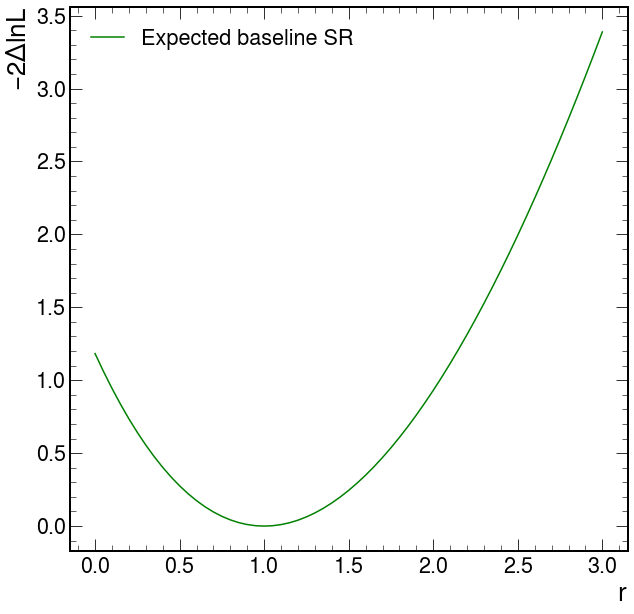

In [13]:
plt.figure()

plt.plot(result['r'][1:], result['deltaNLL'][1:]*2, label=r'Expected baseline SR', c='green')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [14]:
data_cards = {'2018_SR1': sm_card_sr1, '2018_SR2': sm_card_sr2, '2018_CR': sm_card_cr}

combined = card.combineCards(data_cards)

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/81186df8-16d9-4668-9b76-dab92fb02efe
Copying card file to temp: SR_1_card.txt
Copying card file to temp: SR_2_card.txt
Copying card file to temp: CR_card.txt
 dc_2018_SR1=SR_1_card.txt dc_2018_SR2=SR_2_card.txt dc_2018_CR=CR_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/81186df8-16d9-4668-9b76-dab92fb02efe; eval `scramv1 runtime -sh`; combineCards.py  dc_2018_SR1=SR_1_card.txt dc_2018_SR2=SR_2_card.txt dc_2018_CR=CR_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/


In [15]:
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/67ba6c50-1a18-45a7-8de3-e518c865f5a3


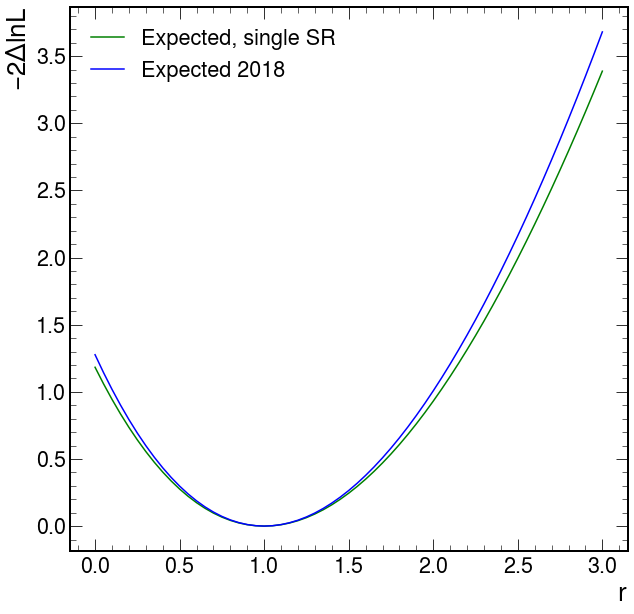

In [16]:
plt.figure()

plt.plot(result['r'][1:], result['deltaNLL'][1:]*2, label=r'Expected, single SR', c='green')
plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected 2018', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

## Combining the years


In [17]:
cache_dir = '../caches/'

cards = {}

for year in ['2016', '2016APV', '2017', '2018']:

    cache_name = 'SS_analysis_%s'%year

    cache = dir_archive(cache_dir+cache_name, serialized=True)
    cache.load()
    output = cache.get('simple_output')
    
    new_hists = {}
    for short_name, long_name in regions:
        new_hists[short_name] = output[long_name][no_data_or_signal]
        new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
        new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
        
        
    cards['SR_1_%s'%year] = makeCardFromHist(
        new_hists,
        'SR_1',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    cards['SR_2_%s'%year] = makeCardFromHist(
        new_hists,
        'SR_2',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    cards['CR_%s'%year] = makeCardFromHist(
        new_hists,
        'CR',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )

Writing cards using histogram: SR_1
Expectation for rare:         0.20
Expectation for TTW:          4.53
Expectation for TTZ:          2.32
Expectation for TTH:          1.67
Expectation for nonprompt:    2.22
Expectation for chargeflip:   0.00
Expectation for conversion:   2.22
Expectation for signal:       1.67
Observation:                  14.83
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1_2016_card.txt
Writing cards using histogram: SR_2
Expectation for rare:         0.14
Expectation for TTW:          2.47
Expectation for TTZ:          1.93
Expectation for TTH:          1.86
Expectation for nonprompt:    2.14
Expectation for chargeflip:   0.00
Expectation for conversion:   2.82
Expectation for signal:       0.88
Observation:                  12.24
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_1

In [18]:
combined_individual = {}

for year in ['2016', '2016APV', '2017', '2018']:
    combined_individual[year] = card.combineCards({
        'SR_1': cards['SR_1_%s'%year],
        'SR_2': cards['SR_2_%s'%year],
        'CR': cards['CR_%s'%year],
    })

combined_all = card.combineCards(cards);

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/f0b2226d-4226-4884-b308-3361a744744a
Copying card file to temp: SR_1_2016_card.txt
Copying card file to temp: SR_2_2016_card.txt
Copying card file to temp: CR_2016_card.txt
 dc_SR_1=SR_1_2016_card.txt dc_SR_2=SR_2_2016_card.txt dc_CR=CR_2016_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/f0b2226d-4226-4884-b308-3361a744744a; eval `scramv1 runtime -sh`; combineCards.py  dc_SR_1=SR_1_2016_card.txt dc_SR_2=SR_2_2016_card.txt dc_CR=CR_2016_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/977a4685-5807-46c9-8670-9c6f05742cdf
Copying card file to temp: SR_1_2016APV_card.txt
Copying card file to temp: SR_2_2016APV_card.txt
Copying card file

In [19]:
result_2016APV = card.nllScan(combined_individual['2016APV'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_2016 = card.nllScan(combined_individual['2016'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_2017 = card.nllScan(combined_individual['2017'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_2018 = card.nllScan(combined_individual['2018'], rmin=0, rmax=3, npoints=61, options=' -v -1')

result_combined_all = card.nllScan(combined_all, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/73921d0f-f0c2-4f58-b55a-42d3eed578e1
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/562895d7-b95a-4ad3-a0b3-6348652b3963
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/c9c32c1e-5111-4bb5-bdcb-507ddd1e5c00
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/279e382b-1cc8-4a23-bfea-ff0324bed77b
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/76cf3a41-abfb-41f2-a5be-1e48f5b5386b


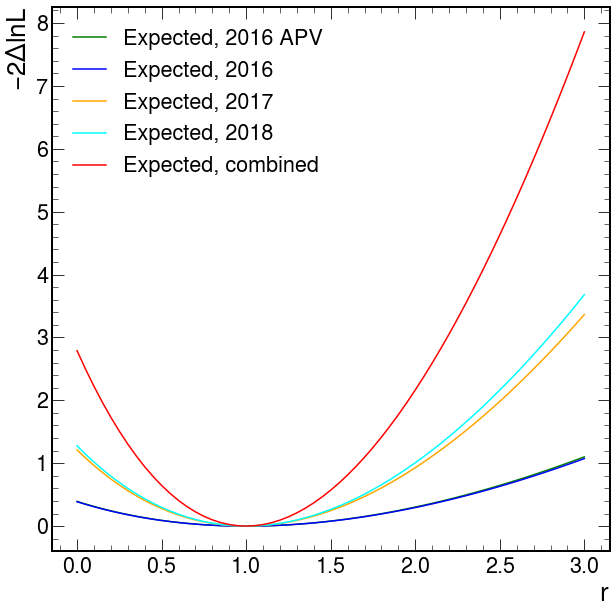

In [20]:
plt.figure()

plt.plot(result_2016APV['r'][1:], result_2016APV['deltaNLL'][1:]*2, label=r'Expected, 2016 APV', c='green')
plt.plot(result_2016['r'][1:], result_2016['deltaNLL'][1:]*2, label=r'Expected, 2016', c='blue')
plt.plot(result_2017['r'][1:], result_2017['deltaNLL'][1:]*2, label=r'Expected, 2017', c='orange')
plt.plot(result_2018['r'][1:], result_2018['deltaNLL'][1:]*2, label=r'Expected, 2018', c='cyan')
plt.plot(result_combined_all['r'][1:], result_combined_all['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [21]:
result_combined_all['deltaNLL'][1]*2

2.789339542388916

In [22]:
card.cleanUp()

Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/2859f39c-8da9-4f92-8ae0-560d11dc0134
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/a4ec6ced-2c08-4343-af34-155f0f419523
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/819f26bf-abf5-4cdc-a8d9-fcf477b611c8
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/d386d6a7-274f-4b58-b870-4b07b1fa98a1
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/c38a2280-145d-4e71-a78e-45af48c30baf
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/da4acbb0-7169-4588-b97c-af10d2529f08
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/9f0ce08a-3583-43f6-bf23-e8bdb838553c
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/d3ebe358-c978-4026-9ef3-311105d803cc
Deleting:  /home

## Adding trilep

In [23]:
# get one of our already existing caches
cache_dir = '../caches/'
cache_name = 'trilep_analysis_2018'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

Data: 0 MC: 28.03


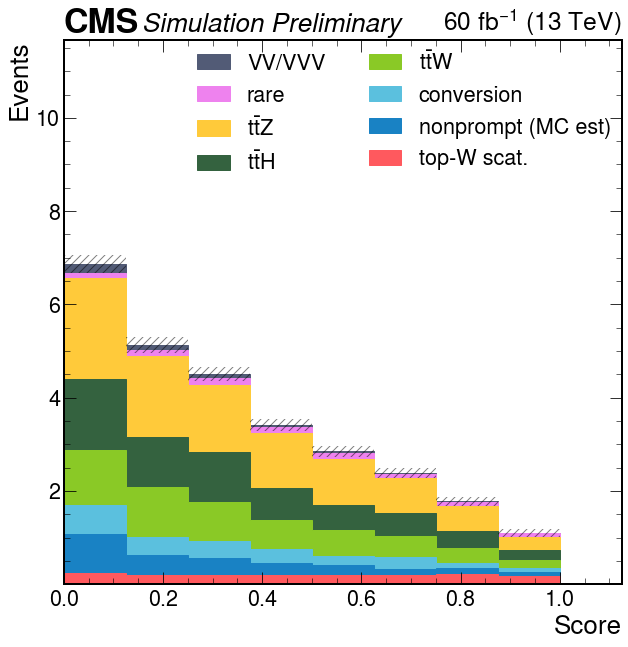

In [24]:
# check out that the histogram we want is actually there
all_processes = [ x[0] for x in output['N_ele'].values().keys() ]
data_all = ['DoubleMuon', 'MuonEG', 'EGamma', 'SingleMuon']
data    = data_all
order   = ['topW_v3', 'np_est_mc', 'conv_mc', 'TTW', 'TTH', 'TTZ','rare', 'diboson']
signals = []
omit    = [ x for x in all_processes if (x not in signals and x not in order and x not in data) ]

lumi = 60

score_bins = hist.Bin("score",          r"N", 8, 0, 1)

mass_bins_coarse = hist.Bin('mass', r'$M\ (GeV)$', [0,100,150,200,400])

makePlot(output, 'node0_score_transform', 'score',
     data=[],
     bins=score_bins, log=False, normalize=False, axis_label='Score',
     new_colors=my_colors, new_labels=my_labels, lumi=lumi,
     order=order,
     signals=signals,
     omit=omit+data,
     #save=os.path.expandvars(plot_dir+sub_dir+'node0_score_transform_pp'),
    )

In [25]:
no_data_or_signal  = re.compile('(?!(%s))'%('|'.join(omit)))

regions = [
    ('trilep_SR', 'node0_score_transform'),
    ('trilep_CR', 'node1_score'),
]

mapping = {
    'rare': ['rare', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'nonprompt': ['np_est_mc'],
    'conversion': ['conv_mc'],
    'signal': ['topW_v3'],
}

new_hists = {}
for short_name, long_name in regions:
    new_hists[short_name] = output[long_name][no_data_or_signal]
    new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
    new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)

In [26]:
systematics = [
    ('ttw_norm', 1.15, 'TTW'),
    ('ttz_norm', 1.10, 'TTZ'),
    ('tth_norm', 1.20, 'TTH'),
    ('rare_norm', 1.20, 'rare'),
    ('nonprompt_norm', 1.30, 'nonprompt'),
    ('conversion_norm', 1.20, 'conversion')
]

sm_card_trilep_sr = makeCardFromHist(
    new_hists,
    'trilep_SR',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_trilep_cr = makeCardFromHist(
    new_hists,
    'trilep_CR',
    overflow='all',
    ext='',
    systematics = systematics,
)

Writing cards using histogram: trilep_SR
Expectation for rare:         1.36
Expectation for TTW:          5.21
Expectation for TTZ:          9.07
Expectation for TTH:          6.00
Expectation for nonprompt:    2.41
Expectation for conversion:   2.31
Expectation for signal:       1.66
Observation:                  28.03
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_SR_card.txt
Writing cards using histogram: trilep_CR
Expectation for rare:         2.91
Expectation for TTW:          10.91
Expectation for TTZ:          11.16
Expectation for TTH:          13.29
Expectation for nonprompt:    1.96
Expectation for conversion:   3.25
Expectation for signal:       0.67
Observation:                  44.17
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_CR_card.txt


In [27]:
data_cards = {'trilep_SR': sm_card_trilep_sr, 'trilep_CR': sm_card_trilep_cr}

combined = card.combineCards(data_cards)

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/dedfe420-db8c-45e6-97fa-86d14580cc7c
Copying card file to temp: trilep_SR_card.txt
Copying card file to temp: trilep_CR_card.txt
 dc_trilep_SR=trilep_SR_card.txt dc_trilep_CR=trilep_CR_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/dedfe420-db8c-45e6-97fa-86d14580cc7c; eval `scramv1 runtime -sh`; combineCards.py  dc_trilep_SR=trilep_SR_card.txt dc_trilep_CR=trilep_CR_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/


In [28]:
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/3a6f5093-f2a0-439e-b6f9-9041f736879a


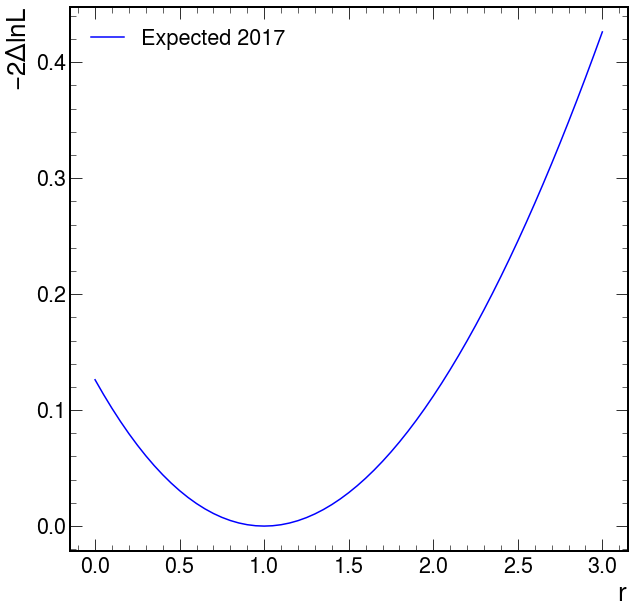

In [29]:
plt.figure()

plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected 2017', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [30]:
cache_dir = '../caches/'

cards_trilep = {}

for year in ['2016', '2016APV', '2017', '2018']:

    cache_name = 'trilep_analysis_%s'%year

    cache = dir_archive(cache_dir+cache_name, serialized=True)
    cache.load()
    output = cache.get('simple_output')
    
    new_hists = {}
    for short_name, long_name in regions:
        new_hists[short_name] = output[long_name][no_data_or_signal]
        new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
        new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
        
        
    cards_trilep['trilep_SR_%s'%year] = makeCardFromHist(
        new_hists,
        'trilep_SR',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    
    cards_trilep['trilep_CR_%s'%year] = makeCardFromHist(
        new_hists,
        'trilep_CR',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )

Writing cards using histogram: trilep_SR
Expectation for rare:         0.15
Expectation for TTW:          0.88
Expectation for TTZ:          3.24
Expectation for TTH:          0.79
Expectation for nonprompt:    0.59
Expectation for conversion:   1.02
Expectation for signal:       0.38
Observation:                  7.05
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_SR_2016_card.txt
Writing cards using histogram: trilep_CR
Expectation for rare:         0.49
Expectation for TTW:          3.21
Expectation for TTZ:          5.32
Expectation for TTH:          3.23
Expectation for nonprompt:    0.69
Expectation for conversion:   1.81
Expectation for signal:       0.18
Observation:                  14.93
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_CR_2016_card.t

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f40ecc3a1f0>
  warnings.warn(


Writing cards using histogram: trilep_SR
Expectation for rare:         1.36
Expectation for TTW:          5.21
Expectation for TTZ:          9.07
Expectation for TTH:          6.00
Expectation for nonprompt:    2.41
Expectation for conversion:   2.31
Expectation for signal:       1.66
Observation:                  28.03
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_SR_2018_card.txt
Writing cards using histogram: trilep_CR
Expectation for rare:         2.91
Expectation for TTW:          10.91
Expectation for TTZ:          11.16
Expectation for TTH:          13.29
Expectation for nonprompt:    1.96
Expectation for conversion:   3.25
Expectation for signal:       0.67
Observation:                  44.17
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_CR_2018_ca

In [31]:
combined_trilep_individual = {}

for year in ['2016', '2016APV', '2017', '2018']:
    combined_trilep_individual[year] = card.combineCards({
        'trilep_SR': cards_trilep['trilep_SR_%s'%year],
        'trilep_CR': cards_trilep['trilep_CR_%s'%year],
    })

combined_trilep_all = card.combineCards(cards_trilep);

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/6ca21f1b-dde1-4b92-ade4-94366b38002d
Copying card file to temp: trilep_SR_2016_card.txt
Copying card file to temp: trilep_CR_2016_card.txt
 dc_trilep_SR=trilep_SR_2016_card.txt dc_trilep_CR=trilep_CR_2016_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/6ca21f1b-dde1-4b92-ade4-94366b38002d; eval `scramv1 runtime -sh`; combineCards.py  dc_trilep_SR=trilep_SR_2016_card.txt dc_trilep_CR=trilep_CR_2016_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/b9bc1277-f339-44cc-8ca8-a498e73d7f35
Copying card file to temp: trilep_SR_2016APV_card.txt
Copying card file to temp: trilep_CR_2016APV_card.txt
 dc_trilep_SR=trilep_SR_2016APV_card.txt dc_tri

In [32]:
combined_trilep_individual

{'2016': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2016_card.txt',
 '2016APV': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2016APV_card.txt',
 '2017': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2017_card.txt',
 '2018': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2018_card.txt'}

In [33]:
result_trilep_2016APV = card.nllScan(combined_trilep_individual['2016APV'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_trilep_2016 = card.nllScan(combined_trilep_individual['2016'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_trilep_2017 = card.nllScan(combined_trilep_individual['2017'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_trilep_2018 = card.nllScan(combined_trilep_individual['2018'], rmin=0, rmax=3, npoints=61, options=' -v -1')

result_trilep_combined_all = card.nllScan(combined_trilep_all, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/ceb3a18b-cef9-41ef-9b9b-46bdc74ac378
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e7abbd88-5581-4232-8294-c9195171eb5c
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/cac39cfd-21d0-4e34-aaa5-8ad38b6fca4b
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e3466cdd-b805-4616-b917-2bc35fc1319b
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/1d082dc4-53e6-40f2-8502-2fd02cf508ba


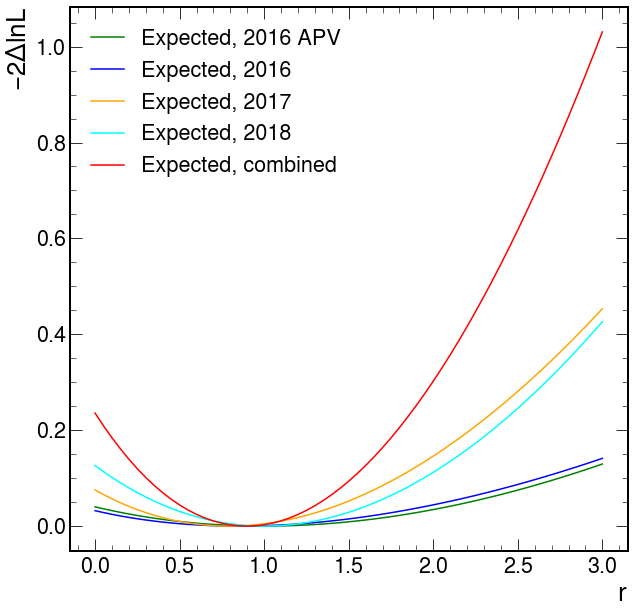

In [34]:
plt.figure()

plt.plot(result_trilep_2016APV['r'][1:], result_trilep_2016APV['deltaNLL'][1:]*2, label=r'Expected, 2016 APV', c='green')
plt.plot(result_trilep_2016['r'][1:], result_trilep_2016['deltaNLL'][1:]*2, label=r'Expected, 2016', c='blue')
plt.plot(result_trilep_2017['r'][1:], result_trilep_2017['deltaNLL'][1:]*2, label=r'Expected, 2017', c='orange')
plt.plot(result_trilep_2018['r'][1:], result_trilep_2018['deltaNLL'][1:]*2, label=r'Expected, 2018', c='cyan')
plt.plot(result_trilep_combined_all['r'][1:], result_trilep_combined_all['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

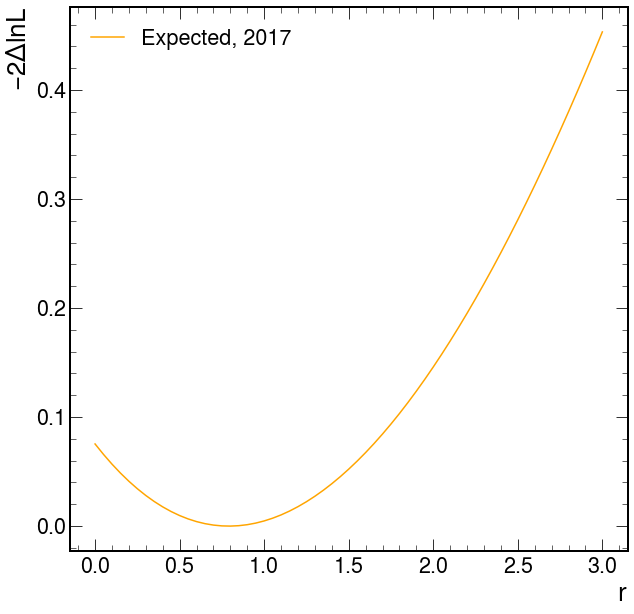

In [44]:
plt.figure()

#plt.plot(result_trilep_2016APV['r'][1:], result_trilep_2016APV['deltaNLL'][1:]*2, label=r'Expected, 2016 APV', c='green')
#plt.plot(result_trilep_2016['r'][1:], result_trilep_2016['deltaNLL'][1:]*2, label=r'Expected, 2016', c='blue')
plt.plot(result_trilep_2017['r'][1:], result_trilep_2017['deltaNLL'][1:]*2, label=r'Expected, 2017', c='orange')
#plt.plot(result_trilep_2018['r'][1:], result_trilep_2018['deltaNLL'][1:]*2, label=r'Expected, 2018', c='cyan')
#plt.plot(result_trilep_combined_all['r'][1:], result_trilep_combined_all['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

# Everything

In [36]:
cards_all = cards
cards_all.update(cards_trilep)

combined_final = card.combineCards(cards_all);

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/7337e8df-8d30-445d-937d-0b4b52c1e8af
Copying card file to temp: SR_1_2016_card.txt
Copying card file to temp: SR_2_2016_card.txt
Copying card file to temp: CR_2016_card.txt
Copying card file to temp: SR_1_2016APV_card.txt
Copying card file to temp: SR_2_2016APV_card.txt
Copying card file to temp: CR_2016APV_card.txt
Copying card file to temp: SR_1_2017_card.txt
Copying card file to temp: SR_2_2017_card.txt
Copying card file to temp: CR_2017_card.txt
Copying card file to temp: SR_1_2018_card.txt
Copying card file to temp: SR_2_2018_card.txt
Copying card file to temp: CR_2018_card.txt
Copying card file to temp: trilep_SR_2016_card.txt
Copying card file to temp: trilep_CR_2016_card.txt
Copying card file to temp: trilep_SR_2016APV_card.txt
Copying card file to temp: trilep_CR_2016APV_card.txt
Copying card file to temp: trilep_SR_2017_card.txt
Copying card file to temp: trilep_CR_2017_card.txt
Copying card f

In [37]:
result_all = card.nllScan(combined_final, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/9d443a6f-5dc5-4317-b010-ae259e649f56


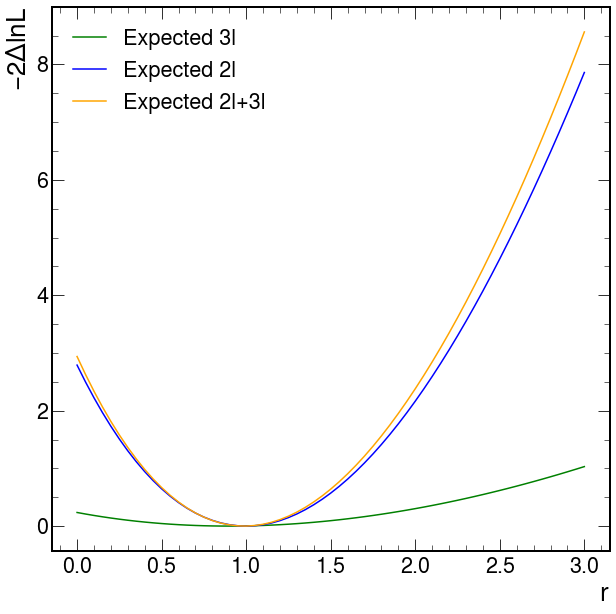

In [38]:
plt.figure()

plt.plot(result_trilep_combined_all['r'][1:], result_trilep_combined_all['deltaNLL'][1:]*2, label=r'Expected 3l', c='green')
plt.plot(result_combined_all['r'][1:], result_combined_all['deltaNLL'][1:]*2, label=r'Expected 2l', c='blue')
plt.plot(result_all['r'][1:], result_all['deltaNLL'][1:]*2, label=r'Expected 2l+3l', c='orange')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [40]:
result_all['deltaNLL'][1]*2

2.9380950927734375